In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
from tqdm.notebook import tqdm
import pims

from adaptive_latents import Pipeline, CenteringTransformer, proSVD, sjPCA, AnimationManager, NumpyTimedDataSource, KernelSmoother
import adaptive_latents.plotting_functions as pf

doi = "https://dx.doi.org/10.11582/2022.00008"

In [2]:
"""
base = pathlib.Path('/media/jgould/Data/CA1_recordings/97288/20210315/')
img = Image.open(base/'97288_20210315_00002.tif')

iscell = np.load(base/'suite2p'/'plane0'/'iscell.npy')
F = np.load(base/'suite2p'/'plane0'/'F.npy')
ncells = int(sum(iscell[:,0]))
"""


"\nbase = pathlib.Path('/media/jgould/Data/CA1_recordings/97288/20210315/')\nimg = Image.open(base/'97288_20210315_00002.tif')\n\niscell = np.load(base/'suite2p'/'plane0'/'iscell.npy')\nF = np.load(base/'suite2p'/'plane0'/'F.npy')\nncells = int(sum(iscell[:,0]))\n"

In [3]:
base = pathlib.Path('/media/jgould/Data/VC_recordings/93562/20200817/')
neural_Fs = 15

iscell = np.load(base/'suite2p'/'plane0'/'iscell.npy')
F_all = np.load(base/'suite2p'/'plane0'/'F.npy')
ncells = int(sum(iscell[:,0]))

def make_beh(fpath):
    pre_beh = pd.read_csv(fpath)
    columns = ["t"] + list(map(lambda a : f"{a[0]}_{a[1]}", zip(pre_beh.iloc[0, 1:], pre_beh.iloc[1, 1:])))
    columns = {pre_beh.columns[i]:columns[i] for i in range(len(columns))}
    beh = pre_beh.rename(columns=columns).iloc[2:].astype(float).reset_index(drop=True)
    beh.t = beh.t/neural_Fs
    return beh


if False:
    F = F_all[:, :F_all.shape[1]//2]
    beh = make_beh(base/"93562_imaging_20200817_withcookies_00001_trackingVideoDLC_resnet50_OPENMINI2P_bottomcameraAug26shuffle1_1030000filtered.csv")
    img =   Image.open(base/"93562_imaging_20200817_withcookies_00001.tif")
    video = pims.Video(base/"93562_imaging_20200817_withcookies_00001_trackingVideo.avi")
else:
    F = F_all[:, F_all.shape[1]//2:]
    img =   Image.open(base/"93562_imaging_20200817_nocookies_00001.tif")
    video = pims.Video(base/"93562_imaging_20200817_nocookies_00001_trackingVideo.avi")
    beh = make_beh(base/"93562_imaging_20200817_nocookies_00001_trackingVideoDLC_resnet50_OPENMINI2P_bottomcameraAug26shuffle1_1030000filtered.csv")



In [4]:
neural_data = NumpyTimedDataSource(F.T, np.arange(F.shape[1]) * 1/neural_Fs)
behavioral_data = NumpyTimedDataSource(beh.loc[:,["mouse_x", "mouse_y"]].to_numpy(), beh.t.to_numpy())
video_t = behavioral_data.t
assert abs(behavioral_data.t[-1] - neural_data.t[-1]) < .1
print(neural_data.t[-1])

579.9333333333333


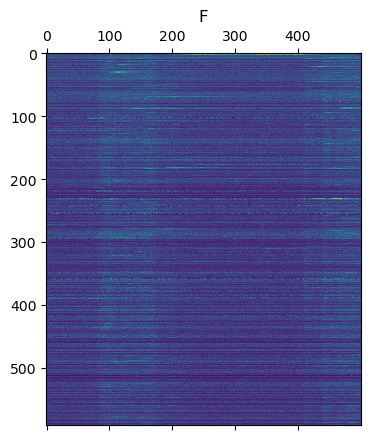

In [5]:
plt.matshow(F[iscell[:,0] == 1,:500])
plt.title("F");

In [6]:
planes = []
for i in range(1000):
    img.seek(i)
    planes.append(np.array(img))

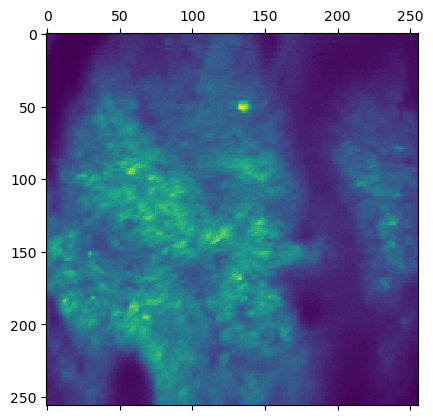

In [7]:
plt.matshow(np.mean(planes, axis=0))

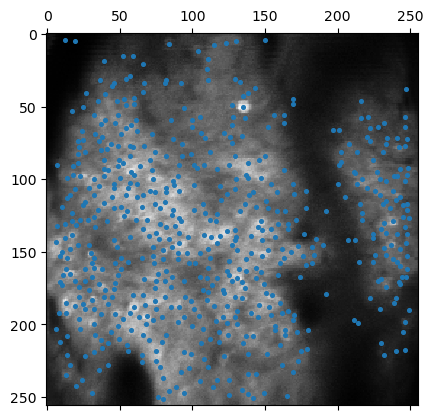

In [28]:

stat = np.load(base/'suite2p'/'plane0'/'stat.npy', allow_pickle=True)
ops = np.load(base/'suite2p'/'plane0'/'ops.npy', allow_pickle=True).item()

im = np.mean(planes, axis=0)
# im = np.zeros((ops['Ly'], ops['Lx']))

# for n in range(0,ncells):
#     ypix = stat[n]['ypix'][~stat[n]['overlap']]
#     xpix = stat[n]['xpix'][~stat[n]['overlap']]
#     im[ypix,xpix] = 0


plt.matshow(-im, cmap='Grays')
xs, ys = list(zip(*[cell['med'] for cell in stat]))

plt.scatter(ys,xs, s=7)
# plt.colorbar()


  0%|          | 0/400 [00:00<?, ?it/s]

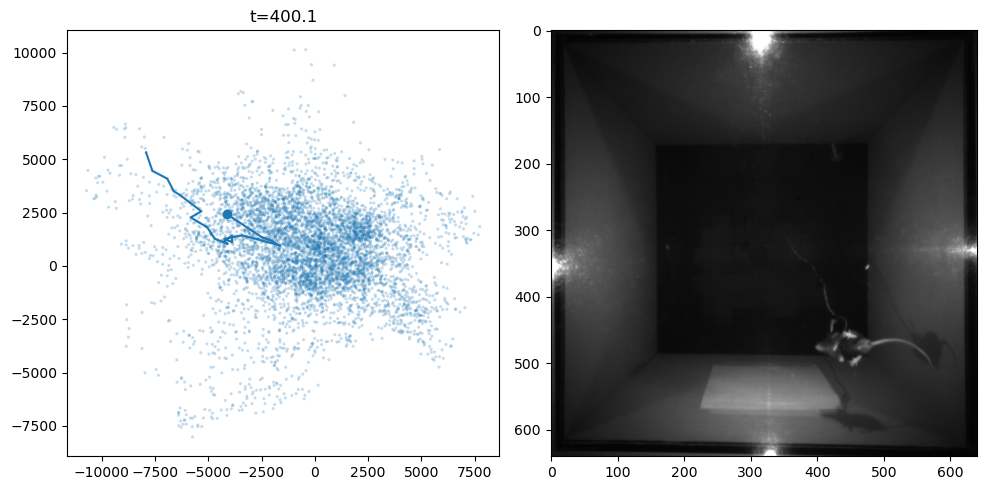

In [9]:
p = Pipeline([
    CenteringTransformer(),
    KernelSmoother(.15*neural_Fs),
    proSVD(k=6),
    sjPCA(),
])
iterator = p.streaming_run_on([neural_data], return_output_stream=True)

last_draw_time = 300
draw_dt = 1/20
exit_time = 400

tq = tqdm(total=exit_time)

with AnimationManager(n_cols=2, figsize=(10,5)) as am:
    output_l = []
    ax: plt.Axes = am.axs[0,0]
    for o, s in iterator:
        tq.update(o.t - tq.n)
        output_l.append(o)
        
        if o.t > last_draw_time + draw_dt:
            old_lims = ax.axis()
            ax.cla()
            outputs = np.squeeze(output_l[50:])
            ax.plot(outputs[-20:,0], outputs[-20:,1])
            ax.scatter(outputs[-1,0], outputs[-1,1])
            ax.scatter(outputs[:,0], outputs[:,1], s=5, alpha=.25, c='C0', edgecolors='none')
            pf.use_bigger_lims(ax, old_lims=old_lims)
            ax.set_title(f"t={o.t:.1f}")
            am.grab_frame()
            last_draw_time = o.t
            
            am.axs[0,1].cla()
            frame = np.argmin(np.abs(video_t - o.t))
            am.axs[0,1].imshow(video[frame])
        
        if o.t > exit_time:
            break
        
        
        
        


